# Lab 3: Optical flow estimation

## Objectives

* Gain a practical understanding of the Lucas-Kanade algorithm.
* Visualize the effects of different choices of parameters and refinement strategies.
* Familiarize yourself with concepts such as warped image and forward-backward consistency.
* Compare the results of different types of methods: Lucas-Kanade and global method (TV-L1 variational method).

Labs 3, 4 and 5 will be done in Python and notebooks (Jupyter or Colab at your convenience). The following [tutorial](https://cs231n.github.io/python-numpy-tutorial/) may be useful to refresh or check some aspects of Python and Numpy.


## Deliverable

**Deadline**: <span style="color:red">P101: 15/02/23 at 12:30h - P102: 16/02/23 at 10:30h</span>

**Submission**:
* The completed Jupyter Notebook with executed cells (all cells must work, i.e. they should run).
* A report with your work, including missing codes and answers to the lab questions (analysis of results, influence of parameters, etc). Address all tasks marked as <font color='green'>**TX.**</font>
* Submit a single zip file in the corresponding delivery task in Aula Global. The submitted zip file has to contain your report and your source code (and all files needed to run it, such as images, other dependencies, etc). The lab will be done in groups of two persons, please submit a single file per group.

We will start by reading and displaying two consecutive frames of a video.

*NOTE: If you want to work with Google Colab you can download a zip file from Google Drive and unzip it here. See example code below.*

`!gdown "1QI1DhTBayClGAFKlh86pFrfhgPfYmC&confirm=t"`

`!unzip file.zip` 

*Ho hem fet tal i com l'any passat seguint les linies de codi següents, ja que ho hem trobat més facil conectant-nos al google drive*

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
sys.path.insert(1,'/content/drive/Shareddrives/VIDEO PROC 3.0/LAB3/lab3')

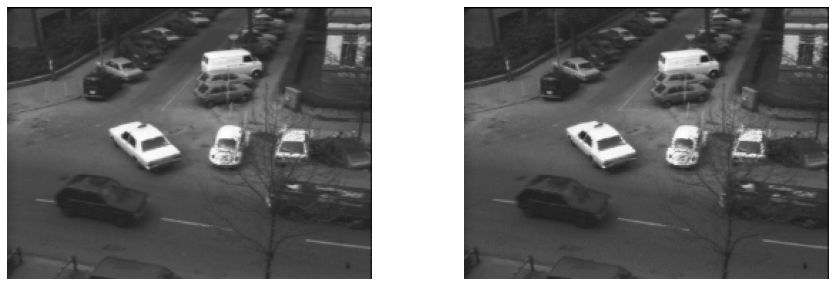

In [3]:
import cv2
import matplotlib
from matplotlib import pyplot as plt

I1 = cv2.imread('/content/drive/Shareddrives/VIDEO PROC 3.0/LAB3/lab3/images/Hamburg/taxi30.pgm',cv2.IMREAD_GRAYSCALE)
I2 = cv2.imread('/content/drive/Shareddrives/VIDEO PROC 3.0/LAB3/lab3/images/Hamburg/taxi31.pgm',cv2.IMREAD_GRAYSCALE)

%matplotlib inline

plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.imshow(I1, cmap='gray')
plt.axis('off')

plt.subplot(122)
plt.imshow(I2, cmap='gray')
plt.axis('off');

### 1. Basic Lucas-Kanade algorithm

You will start coding a function that implements the most basic version of the Lucas-Kanade algorithm, i.e. wihtout the pyramidal scheme and the refinement warpings. The inputs to the function are the two consecutive frames and the size $p$ of the patch $p \times p$ to consider.

*NOTES:* 
* *In order to avoid using certain boundary conditions in the images just estimate the flow everywhere except for a band around the image boundaries (the size of the band is half the patch size $p$).*
* *For computing spatial partial derivatives of an image `img` use the Sobel operator: `cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)` for the partial derivative with respect to $x$ and `cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)` for the partial derivative with respect to $y$.*
* *Before computing the temporal derivative convert the images with `I.astype(np.int32)` to avoid clipping.*

<font color='green'>**T1.** Complete the function below.</font>

In [4]:
import numpy as np
from scipy import signal
from itertools import product

def lucas_kanade_of(I1, I2, patch_size):
    w = patch_size // 2  # [-w, w] window
    
    #convertim les imatges per evitar clipping
    I1 = I1.astype(np.int32)/255
    I2 = I2.astype(np.int32)/255

    height = I1.shape[0]
    width = I1.shape[1]

    #calculem les derivades parcials
    I2_dx = cv2.Sobel(I2, cv2.CV_64F, 1, 0, ksize=3)
    I2_dy = cv2.Sobel(I2, cv2.CV_64F, 0, 1, ksize=3)
    t = I2-I1

    #iniciem las matrius amb les seves respectives mesures
    A = np.zeros((patch_size**2,2))
    b = np.zeros((patch_size**2,1))
    flow = np.zeros((height, width, 2))
    
    # remove a band around image boundaries to avoid boundary conditions
    for i, j in product(range(w, height - w), range(w, width - w)):        
      Ix = I2_dx[i-w:i+w+1, j-w:j+w+1].flatten()
      Iy = I2_dy[i-w:i+w+1, j-w:j+w+1].flatten()
      It = t[i-w:i+w+1, j-w:j+w+1].flatten()
      #least square approximation
      A[:,0] = Ix[:]
      A[:,1] = Iy[:]
      b[:,0] = It[:]
      #calculamos la multipplicacion de matrices con la funcion dot()
      AtA = np.dot(np.transpose(A),A)   #A.T*A
      Atb = np.dot(np.transpose(A),-b)  #A.T*b
      #calculamos el flow(u,v)
      flow[i,j,0] = np.dot(np.linalg.inv(AtA),Atb)[0]
      flow[i,j,1] = np.dot(np.linalg.inv(AtA),Atb)[1]

    return flow
    

The next cell estimates the optical flow with the basic Lucas-Kanade algorithm.

In [5]:
flow = lucas_kanade_of(I1, I2, 15)

The following cell displays the estimated optical flow (every 4 pixels) as a quiver plot.

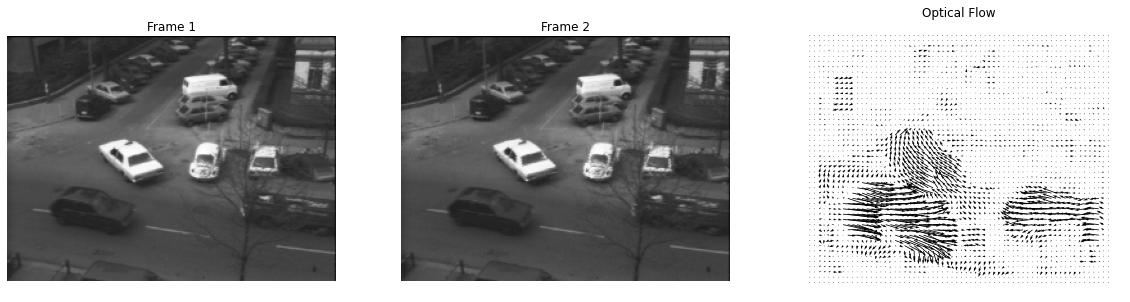

In [6]:
step = 4
plt.figure(figsize=(20, 5))

plt.subplot(131)
plt.title('Frame 1')
plt.imshow(I1, cmap='gray')
plt.axis('off')

plt.subplot(132)
plt.title('Frame 2')
plt.imshow(I2, cmap='gray')
plt.axis('off')

plt.subplot(133)
plt.title('Optical Flow')
plt.quiver(np.arange(0, 256, step), np.arange(190, -1, -step), 
           flow[::step, ::step, 0], -flow[::step, ::step, 1])
plt.axis('off');

A more convenient and usual representation of the optical flow is by using a color code, where color represents the direction and the intensity denotes the length of displacement vector.

OF color coding | Superimposed vectors
- | - 
![alt](OF_color_code.png) | ![alt](OF_color_code_arrows.png)

In the next cell we will display the estimated flow with the color code.

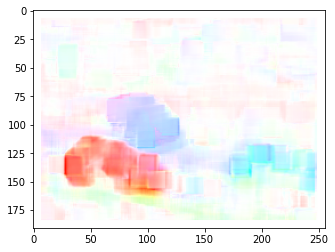

In [7]:
from utils import compute_color_flow_map
from utils import read_flo_file


flow_image = compute_color_flow_map(flow)
plt.imshow(flow_image)
plt.show()

<font color='green'>**T2.** Comment the obtained result. Is the estimated optical flow the expected one? Justify your answer. </font>

### 2. Some evaluation and analysis functions

#### 2.1 Quantitative evaluation of the estimated optical flow
We saw (both in the theoretical lectures and the seminar of optical flow) that two of the most common performance measures are the *Endpoint Error (EPE)* and the *Angular Error (AE)*.

<font color='green'>**T3.** Complete the two functions below that compute the EPE and AE from a pair of input flows.</font>

*NOTE: The ground-truth optical flow is unknown at certain pixel locations. Those pixels are marked with a certain value in the ground-truth flow: UNKNOWN_FLOW_THRESH = 1e9. The functions you have to code need to take this aspect into account so as not to compute the error in those pixels.*

In [8]:
def endpointError(flow1, flow2):
    epe = np.sqrt(np.square(flow1[:,:,0]-flow2[:,:,0])+np.square(flow1[:,:,1]-flow2[:,:,1]))
    #posem aquesta restricció, ja que sino seran valors NaN, i no ens donarà un resultat fiable
    epe[flow2[:,:,0] > 1e9] = 0
    return epe

def angularError(flow1, flow2):   
    num = (flow1[:,:,0]*flow2[:,:,0]) + (flow1[:,:,1]*flow2[:,:,1]) + 1
    den = np.sqrt(np.square(flow1[:,:,0]) + np.square(flow1[:,:,1]) + 1) * np.sqrt(np.square(flow2[:,:,0]) + np.square(flow2[:,:,1]) + 1)
    ae = np.arccos(num/den)
    #posem aquesta restricció, ja que sino seran valors NaN, i no ens donarà un resultat fiable
    ae[flow2[:,:,0] > 1e9] = 0
    return ae

In order to test the previous functions and compute the optical flow errors we will switch to a new pair of images whose ground truth optical flow is known.

In [9]:
I1 = cv2.imread('/content/drive/Shareddrives/VIDEO PROC 3.0/LAB3/lab3/images/Middlebury/frame10.png',cv2.IMREAD_GRAYSCALE)
I2 = cv2.imread('/content/drive/Shareddrives/VIDEO PROC 3.0/LAB3/lab3/images/Middlebury/frame11.png',cv2.IMREAD_GRAYSCALE)

flow = lucas_kanade_of(I1, I2, 15)

The following cell displays the estimated optical flow, it also reads the ground truth flow and displays it.

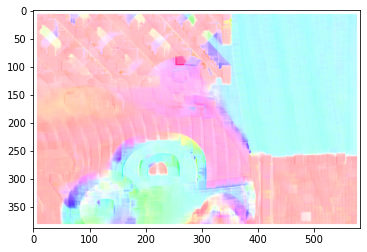

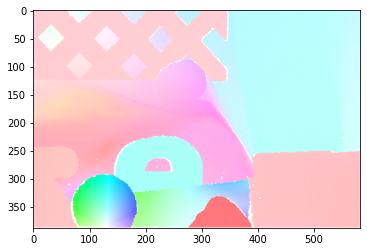

In [10]:
from utils import read_flo_file

flow_image = compute_color_flow_map(flow)
plt.imshow(flow_image)
plt.show()

gtflow = read_flo_file('/content/drive/Shareddrives/VIDEO PROC 3.0/LAB3/lab3/images/Middlebury/flow10.flo')
gtflow_image = compute_color_flow_map(gtflow)
plt.imshow(gtflow_image)
plt.show()

The next cell computes both errors and displays two images with the EPE and AE per pixel.

1.119816681077863
0.7372579999972702


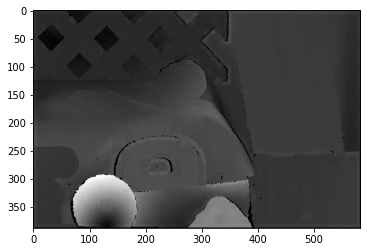

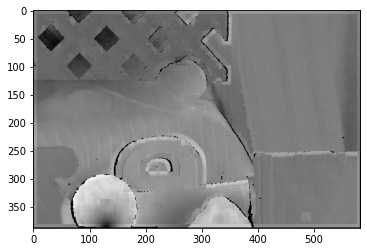

In [11]:
epe = endpointError(flow, gtflow)
ae = angularError(flow, gtflow)

print(np.mean(epe))
print(np.mean(ae))

plt.imshow(epe,cmap='gray')
plt.show()

plt.imshow(ae,cmap='gray')
plt.show()

<font color='green'>**T4.** Compare the estimated optical flows with the basic Lucas-Kanade algorithm for different patch size: $9 \times 9$, $17 \times 17$ and $25 \times 25$. Provide both a quantitative and qualitative comparison.</font>

1.1147658641107903
0.732293301689709


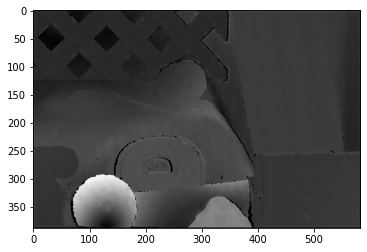

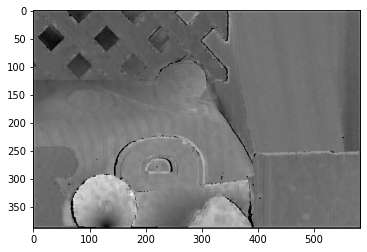

In [12]:
#patch size = 9
flow = lucas_kanade_of(I1, I2, 9)
epe = endpointError(flow, gtflow)
ae = angularError(flow, gtflow)

print(np.mean(epe))
print(np.mean(ae))

plt.imshow(epe,cmap='gray')
plt.show()

plt.imshow(ae,cmap='gray')
plt.show()

1.1215481203394488
0.7389728985710611


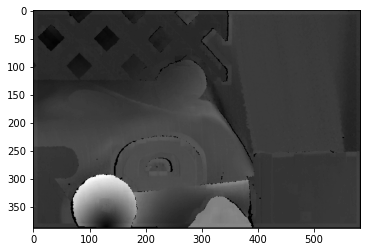

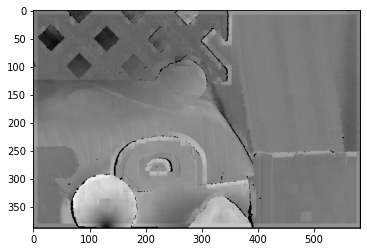

In [13]:
#patch size = 17
flow = lucas_kanade_of(I1, I2, 17)
epe = endpointError(flow, gtflow)
ae = angularError(flow, gtflow)

print(np.mean(epe))
print(np.mean(ae))

plt.imshow(epe,cmap='gray')
plt.show()

plt.imshow(ae,cmap='gray')
plt.show()

1.1286828890831233
0.746046231019515


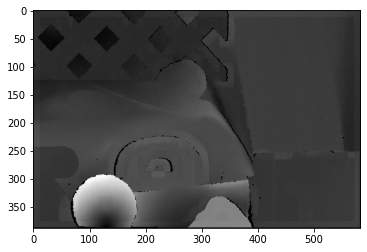

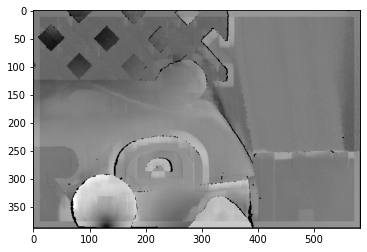

In [14]:
#patch size = 25
flow = lucas_kanade_of(I1, I2, 25)
epe = endpointError(flow, gtflow)
ae = angularError(flow, gtflow)

print(np.mean(epe))
print(np.mean(ae))

plt.imshow(epe,cmap='gray')
plt.show()

plt.imshow(ae,cmap='gray')
plt.show()



#### 2.2 Analysis of the eigenvalues of the matrix in the Lucas-Kanade system of equations
We saw that the values of the eigenvalues of the matrix in the Lucas-Kanade system of equations have a geometrical meaning and a direct implication in the performance of the estimated flow. Remember that the eigenvalues of that matrix are used in the Harris corner detector, more concretely in the $R$ value.

<font color='green'>**T5.** Compute and visualize the $R$ value at every pixel. Comment the results you obtain.</font>

In [15]:
def eigenvalues(image, patch_size):
  w = patch_size // 2  # [-w, w] window
  
  #convertim les imatges per evitar clipping
  I = image.astype(np.int32)/255

  height = I.shape[0]
  width = I.shape[1]

  #calculem les derivades parcials
  I_dx = cv2.Sobel(I, cv2.CV_64F, 1, 0, ksize=3)
  I_dy = cv2.Sobel(I, cv2.CV_64F, 0, 1, ksize=3)

  #iniciem las matrius amb les seves respectives mesures
  A = np.zeros((patch_size**2,2))
  
  e1 = np.zeros((height, width))
  e2 = np.zeros((height, width))
  
  # remove a band around image boundaries to avoid boundary conditions
  for i, j in product(range(w, height - w), range(w, width - w)):        
    Ix = I_dx[i-w:i+w+1, j-w:j+w+1].flatten()
    Iy = I_dy[i-w:i+w+1, j-w:j+w+1].flatten()

    #least square approximation
    A[:,0] = Ix[:]
    A[:,1] = Iy[:]

    #calculamos la multiplicacion de matrices con la funcion dot()
    AtA = np.dot(np.transpose(A),A)   #A.T*A

    #calculem els eigenvalues
    e1[i,j] = np.linalg.eig(AtA)[0][0]
    e2[i,j] = np.linalg.eig(AtA)[0][1]

  return e1, e2

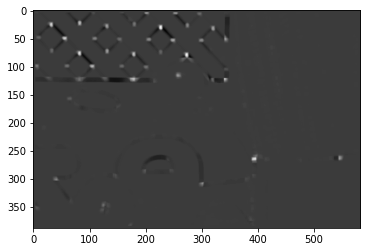

In [16]:
#per calcular R seguim la formula R = det(M) − k trace(M)^2
#calculem els eigenvalues a partir de la funció creada a la cela anterior
e1, e2 = eigenvalues(I2, 9)
#sabem que el producte dels vaps es el det(M) i la suma es la diagonal(M)
det_M = e1 * e2
trace_M = e1 + e2

#agafem un valor entre 0.04 i 0.06
k = 0.05    
R = det_M - k*trace_M**2

plt.imshow(R,cmap='gray')
plt.show()

### 3. Pyramidal and iterated Lucas-Kanade algorithm
Now you will adapt the previous coded function to a more sophisticated version of the Lucas-Kanade algorithm that is able to cope with larger displacements. For that you need to implement the pyramid scheme and the iterated refinements of the flow at each scale of the pyramid. Some functions useful for that are already provided.

<font color='green'>**T6.** Complete the function `lucas_kanade_of_warp`. This function estimates the optical flow between an image and another image warped with a given flow.</font>

<font color='green'>**T7.** Complete the function `pyr_lucas_kanade_of`. This function is the pyramidal version of the Lucas-Kanade, at each scale it performs an iterated refinement of the estimated flow which is based on warped images.</font>

*NOTE: We recommend to use the function `cv2.pyrUp(img, image_size)` to upsample the image with the desired `image_size` in order to recover odd image dimensions after downsampling and upsampling .*

In [17]:
import math
   
def warp_image_flow(image, flow):    
    h, w = flow.shape[:2]    
    flow = flow.astype(np.float32)
    flow[..., 0] += np.arange(w)
    flow[..., 1] += np.arange(h)[:, np.newaxis]    
    warped_image = cv2.remap(image, flow[..., 0], flow[..., 1], cv2.INTER_LINEAR)    
    return warped_image

from scipy import signal

def lucas_kanade_of_warp(I1, I2, patch_size, flow):
    #calculem el flow de la imatge warped 
    I2 = warp_image_flow(I2,flow)
    #calculem el lucas kanade de la imatge 1 i la imatge amb el flow warped
    flow = lucas_kanade_of(I1,I2,patch_size)
    return flow


# generate Gaussian pyramid (scale factor = 2)
def generate_pyramid(image, scales):
    I = image.copy()
    pyramid = [I]
    for i in range(scales-1):
        I = cv2.pyrDown(I)
        pyramid.append(I)
    return pyramid

# pyramid Lucas-Kanade
def pyr_lucas_kanade_of(image1, image2, patch_size, scales=1, warpings=1):   
    #generem les dues piramides de les dues imatges
    py_I1 = generate_pyramid(image1, scales)
    py_I2 = generate_pyramid(image2, scales)
    
    #calculem les mides de la piramide per crear la matriu del flow de les mateixes mides
    height = py_I1[scales-1].shape[0]
    width = py_I1[scales-1].shape[1]
    flow = np.zeros([height,width,2])

    #recorrem els nivells en ordre invers (de més petit a més gran)
    for lavel in reversed(range(scales)):
      for i in range(warpings):
        #calculem el flow a partir de la warped image
        flow = flow + lucas_kanade_of_warp(py_I1[lavel], py_I2[lavel], patch_size, flow)
      #si encara queden nivells per recorrer, que fagi un upsampled de la imatge ii agafi la mida següent
      if lavel > 0:
        flow = cv2.pyrUp(flow, np.shape(py_I1[lavel-1]))
        
    return flow

The following cell estimates the optical flow with the impoved Lucas-Kanade function

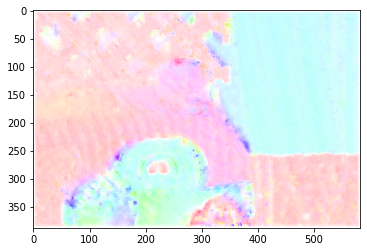

In [18]:
#pyr_lucas_kanade_of(image1, image2, patch_size, scales=1, warpings=1)
flow = pyr_lucas_kanade_of(I1, I2, 7, 2, 1)

rgb_flow = compute_color_flow_map(flow)
plt.imshow(rgb_flow)
plt.show()

<font color='green'>**T8.** Use and adapt the following code to calculate the difference of the two consecutive frames and the difference of one frame and the other frame warped with the estimated flow. Analyse and comment both results.</font>

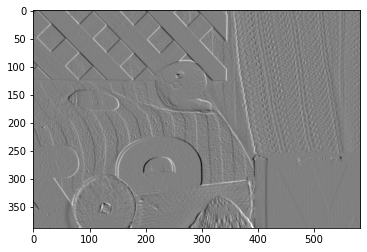

Max diff of two consecutive frames:  144
Min diff of two consecutive frames:  -108


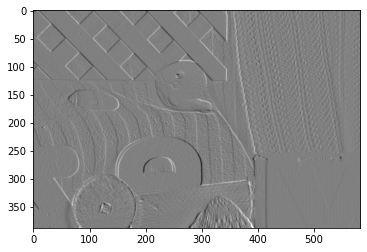

Max diff of one frame and other frame warped:  144
Min diff of one frame and other frame warped:  -92


In [19]:
I1_b= np.int32(I1)
I2_b= np.int32(I2)
diff = I2_b - I1_b
plt.imshow(diff,cmap='gray',vmin=-100,vmax=100)
plt.show()
print('Max diff of two consecutive frames: ', np.amax(diff))
print('Min diff of two consecutive frames: ', np.amin(diff))

#la diferencia entre un frame i un frame warped
I_warp = warp_image_flow(I2, flow)
diff = I_warp - I1_b
plt.imshow(diff,cmap='gray',vmin=-100,vmax=100)
plt.show()
print('Max diff of one frame and other frame warped: ', np.amax(diff))
print('Min diff of one frame and other frame warped: ', np.amin(diff))

<font color='green'>**T9.** Vary the input parameters in the `pyr_lucas_kanade_of`. Analyse the effect of each parameter.</font>

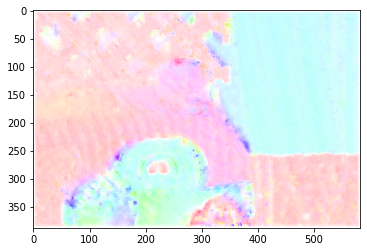

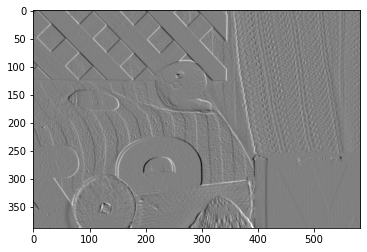

Max diff of to consecutive frames:  144
Min diff of to consecutive frames:  -108


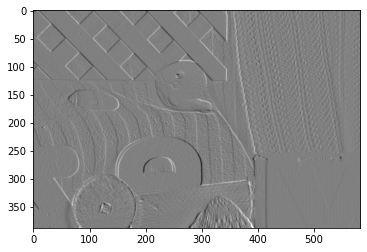

Max diff of one frame and other frame warped:  144
Min diff of one frame and other frame warped:  -92


In [23]:
#pyr_lucas_kanade_of(image1, image2, patch_size, scales=1, warpings=1)
flow = pyr_lucas_kanade_of(I1, I2, 7, 2, 1)

rgb_flow = compute_color_flow_map(flow)
plt.imshow(rgb_flow)
plt.show()

I1_b= np.int32(I1)
I2_b= np.int32(I2)
diff = I2_b - I1_b
plt.imshow(diff,cmap='gray',vmin=-100,vmax=100)
plt.show()
print('Max diff of to consecutive frames: ', np.amax(diff))
print('Min diff of to consecutive frames: ', np.amin(diff))

#la diferencia entre un frame i un frame warped
I_warp = warp_image_flow(I2, flow)
diff = I_warp - I1_b
plt.imshow(diff,cmap='gray',vmin=-100,vmax=100)
plt.show()
print('Max diff of one frame and other frame warped: ', np.amax(diff))
print('Min diff of one frame and other frame warped: ', np.amin(diff))

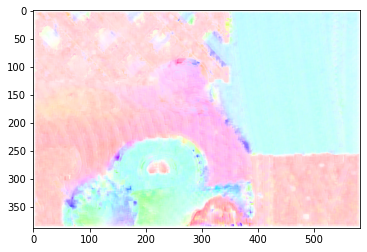

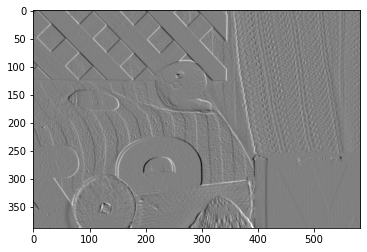

Max diff of to consecutive frames:  144
Min diff of to consecutive frames:  -108


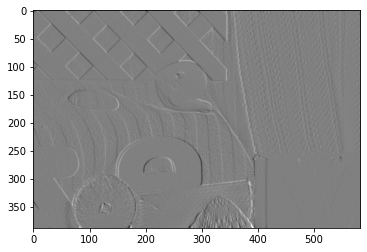

Max diff of one frame and other frame warped:  144
Min diff of one frame and other frame warped:  -82


In [24]:
#pyr_lucas_kanade_of(image1, image2, patch_size, scales=1, warpings=1)
flow = pyr_lucas_kanade_of(I1, I2, 7, 2, 3)

rgb_flow = compute_color_flow_map(flow)
plt.imshow(rgb_flow)
plt.show()

I1_b= np.int32(I1)
I2_b= np.int32(I2)
diff = I2_b - I1_b
plt.imshow(diff,cmap='gray',vmin=-100,vmax=100)
plt.show()
print('Max diff of to consecutive frames: ', np.amax(diff))
print('Min diff of to consecutive frames: ', np.amin(diff))

#la diferencia entre un frame i un frame warped
I_warp = warp_image_flow(I2, flow)
diff = I_warp - I1_b
plt.imshow(diff,cmap='gray',vmin=-100,vmax=100)
plt.show()
print('Max diff of one frame and other frame warped: ', np.amax(diff))
print('Min diff of one frame and other frame warped: ', np.amin(diff))

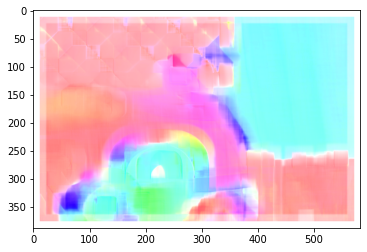

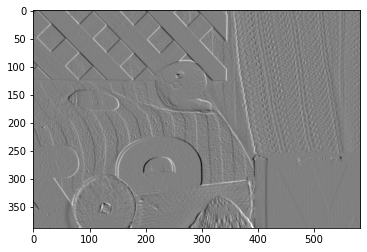

Max diff of to consecutive frames:  144
Min diff of to consecutive frames:  -108


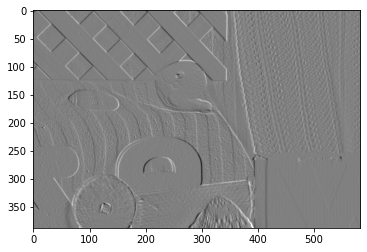

Max diff of one frame and other frame warped:  144
Min diff of one frame and other frame warped:  -93


In [22]:
#pyr_lucas_kanade_of(image1, image2, patch_size, scales=1, warpings=1)
flow = pyr_lucas_kanade_of(I1, I2, 25, 2, 1)

rgb_flow = compute_color_flow_map(flow)
plt.imshow(rgb_flow)
plt.show()

I1_b= np.int32(I1)
I2_b= np.int32(I2)
diff = I2_b - I1_b
plt.imshow(diff,cmap='gray',vmin=-100,vmax=100)
plt.show()
print('Max diff of to consecutive frames: ', np.amax(diff))
print('Min diff of to consecutive frames: ', np.amin(diff))

#la diferencia entre un frame i un frame warped
I_warp = warp_image_flow(I2, flow)
diff = I_warp - I1_b
plt.imshow(diff,cmap='gray',vmin=-100,vmax=100)
plt.show()
print('Max diff of one frame and other frame warped: ', np.amax(diff))
print('Min diff of one frame and other frame warped: ', np.amin(diff))

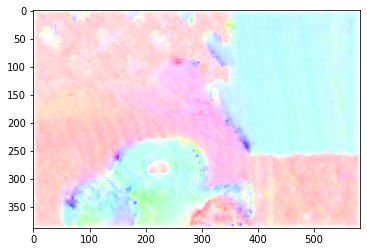

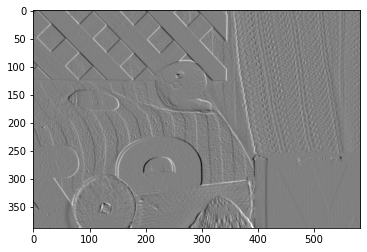

Max diff of to consecutive frames:  144
Min diff of to consecutive frames:  -108


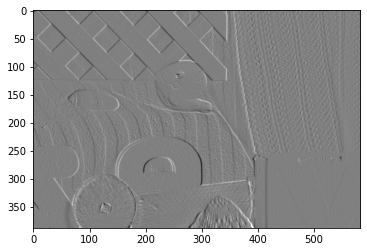

Max diff of one frame and other frame warped:  144
Min diff of one frame and other frame warped:  -86


In [27]:
#pyr_lucas_kanade_of(image1, image2, patch_size, scales=1, warpings=1)
flow = pyr_lucas_kanade_of(I1, I2, 7, 3, 1)

rgb_flow = compute_color_flow_map(flow)
plt.imshow(rgb_flow)
plt.show()

I1_b= np.int32(I1)
I2_b= np.int32(I2)
diff = I2_b - I1_b
plt.imshow(diff,cmap='gray',vmin=-100,vmax=100)
plt.show()
print('Max diff of to consecutive frames: ', np.amax(diff))
print('Min diff of to consecutive frames: ', np.amin(diff))

#la diferencia entre un frame i un frame warped
I_warp = warp_image_flow(I2, flow)
diff = I_warp - I1_b
plt.imshow(diff,cmap='gray',vmin=-100,vmax=100)
plt.show()
print('Max diff of one frame and other frame warped: ', np.amax(diff))
print('Min diff of one frame and other frame warped: ', np.amin(diff))

### 4. Other optical flow estimation methods

#### 4.1 TV-L1
The TV-L1 method was presented in [1]. It is a global optical flow estimation method. In particular, it is a variational method that minimizes an energy formed by a robust data term based on the optical flow constraint and a regularization term based on the Total Variation of the components of the optical flow. It is an algorithm with an extended use, especially before the advent of deep-learning-based optical flow methods.

Let $I_1$ and $I_2$ be two consecutive gray-scale frames of a video and let $\Omega \subseteq \mathbb{R}^2$ be the frame domain. The TV-L1 method finds the optical flow $\mathbf{u}(\mathbf{x})=(u(\mathbf{x}),v(\mathbf{x}))$ that minimizes the following energy:
$$ \lambda \int_{\Omega} |I_2(\mathbf{x}+\mathbf{u}(\mathbf{x})) - I_1(\mathbf{x})| d\mathbf{x} + \int_\Omega ( \| \nabla u(\mathbf{x})\| + \| \nabla v(\mathbf{x})\|)d\mathbf{x} $$
After a Taylor expansion of $I_2(\mathbf{x}+\mathbf{u})$ the previous energy can be written as:
$$ \lambda \int_{\Omega} |\nabla I_2(\mathbf{x}) \cdot \mathbf{u}(\mathbf{x}) + I_2(\mathbf{x}) - I_1(\mathbf{x})| d\mathbf{x} + \int_\Omega ( \| \nabla u(\mathbf{x})\| + \| \nabla v(\mathbf{x})\|)d\mathbf{x} $$

[1] Christopher Zach, Thomas Pock, and Horst Bischof. A duality based approach for realtime tv-l1 optical flow. In Pattern Recognition, pages 214–223. Springer, 2007.

<font color='green'>**T10.** Execute the following cell to estimate and visualize the estimated flow with the TV-L1 method. Compare, both quantitatively and qualitatively, the new result with the previous ones. How does the value of $\lambda$ affect the result?</font>

*NOTE: To run this method (unless you are using Google Colab) you need to install the opencv-contrib-python package to get the cv2.optflow module.*

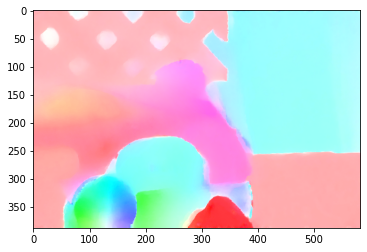

In [ ]:
optical_flow = cv2.optflow.createOptFlow_DualTVL1()
optical_flow.setLambda(0.10) # by default lambda = 0.15, use this command in order to change its value
flow = optical_flow.calc(I1, I2, None)
rgb_flow = compute_color_flow_map(flow)
plt.imshow(rgb_flow)
plt.show()

### 5. Forward-backward consistency

The goal of this last part of the lab is to evaluate the forward-backward consistency that makes use of both the forward and backward flows.

<font color='green'>**T11.** Use the two frames from Sintel (below) and the TV-L1 estimated flow on these frames to evaluate the forward-backward consistency at each pixel. Compare the result with the image `images/Sintel/occlusions_frame_0016.png` and comment your obervations.</font>

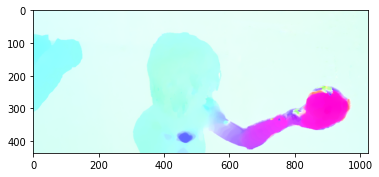

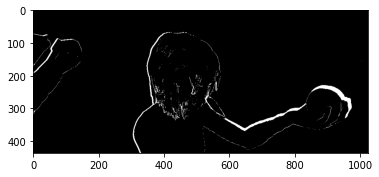

In [29]:
I1 = cv2.imread('/content/drive/Shareddrives/VIDEO PROC 3.0/LAB3/lab3/images/Sintel/frame_0016.png',cv2.IMREAD_GRAYSCALE)
I2 = cv2.imread('/content/drive/Shareddrives/VIDEO PROC 3.0/LAB3/lab3/images/Sintel/frame_0017.png',cv2.IMREAD_GRAYSCALE)

optical_flow = cv2.optflow.createOptFlow_DualTVL1()
optical_flow.setLambda(0.15) # by default lambda = 0.15, use this command in order to change its value
flow = optical_flow.calc(I1, I2, None)
rgb_flow = compute_color_flow_map(flow)
plt.imshow(rgb_flow)
plt.show()

Iocclusions = cv2.imread('/content/drive/Shareddrives/VIDEO PROC 3.0/LAB3/lab3/images/Sintel/occlusions_frame_0016.png',cv2.IMREAD_GRAYSCALE)
plt.imshow(Iocclusions, cmap='gray')
plt.show()

<font color='green'>**T12.** Warp the second frame according to the estimated flow and also to the ground truth flow (`images/Sintel/frame_0016.flo`). Compare and comment the results in both cases.</font>

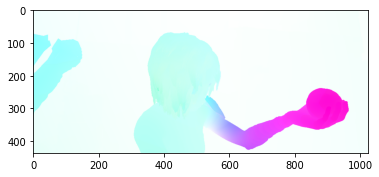

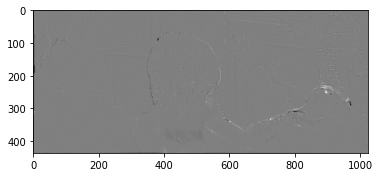

Max diff of 2nd frame and the estimated flow:  173
Min diff of 2nd frame and the estimated flow:  -172


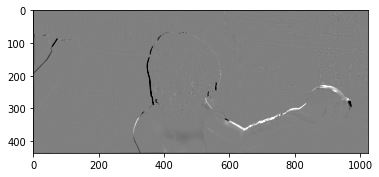

Max diff of 2nd frame and the ground truth flow:  194
Min diff of 2nd frame and the ground truth flow:  -249


In [ ]:
gtflow = read_flo_file('/content/drive/Shareddrives/VIDEO PROC 3.0/LAB3/lab3/images/Sintel/frame_0016.flo')
gtflow_image = compute_color_flow_map(gtflow)
plt.imshow(gtflow_image)
plt.show()

I_warp = warp_image_flow(I2, flow)
diff = np.int32(I_warp) - np.int32(I1)
plt.imshow(diff,cmap='gray',vmin=-100,vmax=100)
plt.show()
print('Max diff of 2nd frame and the estimated flow: ', np.amax(diff))
print('Min diff of 2nd frame and the estimated flow: ', np.amin(diff))

I_warp = warp_image_flow(I2, gtflow)
diff = np.int32(I_warp) - np.int32(I1)
plt.imshow(diff,cmap='gray',vmin=-100,vmax=100)
plt.show()
print('Max diff of 2nd frame and the ground truth flow: ', np.amax(diff))
print('Min diff of 2nd frame and the ground truth flow: ', np.amin(diff))